Generating strategies...
Strategy Space Size: (256, 8)
Precomputing binomials...
Calculating Scenario: Immediate...
  -> Cooperation Rate: 0.8997 (Time: 11.63s)
Calculating Scenario: Gradual...
  -> Cooperation Rate: 0.7694 (Time: 6.52s)
Calculating Scenario: Delayed...
  -> Cooperation Rate: 0.6759 (Time: 5.87s)
Calculating Scenario: None...
  -> Cooperation Rate: 0.1475 (Time: 5.35s)

Plotting Results...

Reproduction complete. Values should match Paper Fig 4b:
Immediate: ~0.90
Gradual:   ~0.77
Delayed:   ~0.68
None:      ~0.15


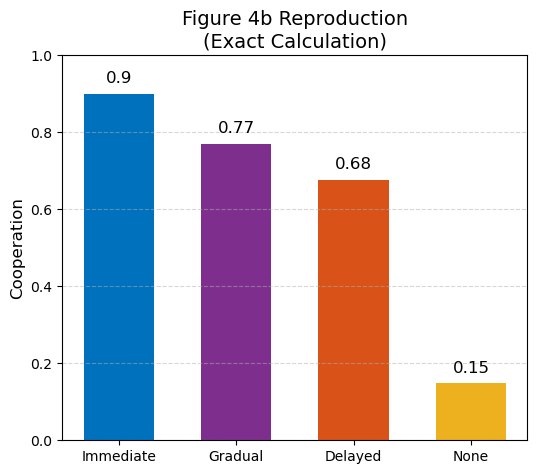

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from numba import njit, prange
import pandas as pd
import time

# ==========================================
# 1. Configuration & Constants (from Paper/MATLAB)
# ==========================================
N = 100         # Population size
n = 4           # Group size (4-player PGG)
beta = 10.0     # Selection strength (strong selection)
c = 1.0         # Cost of cooperation
n_states = 5    # 5 States (1=Best, 5=Worst)

# Strategy space for memory-1 strategies with n=4
# Input to strategy: (My_Prev_Action, Num_Others_Coop)
# My_Prev: 2 options (C, D)
# Num_Others: 4 options (0, 1, 2, 3) --> Wait, strictly n=4 group means 0..3 others.
# Total params = 2 * 4 = 8 bits.
# Total pure strategies = 2^8 = 256.

# ==========================================
# 2. Helper Functions
# ==========================================

def get_all_strategies(n_group):
    """
    Generates all deterministic memory-1 strategies.
    For n=4, a strategy is a vector of length 2*n = 8.
    Format matches MATLAB: [p(C|n-1)..p(C|0), p(D|n-1)..p(D|0)]
    """
    # The MATLAB code uses 2*n bits for the strategy definition
    # For n=4, this is 8 bits.
    num_strategies = 2**(2 * n_group)
    indices = np.arange(num_strategies)
    # Create bit matrix (Strategies x Parameters)
    # We iterate backwards to match the dec2bin logic
    strats = ((indices[:, None] & (1 << np.arange(2 * n_group)[::-1])) > 0).astype(np.int64)
    return strats

def calc_binom_matrix(N, n):
    """
    Precompute hypergeometric probabilities for group sampling.
    Returns matrix [N_mutants_in_pop, k_mutants_in_group]
    """
    bm = np.zeros((N, n + 1))
    for M in range(N): # M other mutants in pop
        for k in range(n + 1): # k mutants in neighbors
            # Drawing n-1 neighbors from N-1 individuals
            # We want prob that k neighbors are mutants given M mutants in pool
            total_ways = comb(N - 1, n - 1)
            if total_ways > 0:
                ways = comb(M, k) * comb(N - 1 - M, n - 1 - k)
                bm[M, k] = ways / total_ways
    return bm

# ==========================================
# 3. Numba Core: M-State Stochastic Game Engine
# ==========================================

@njit(fastmath=True)
def solve_markov_chain(M_trans):
    """Solves v * M = v for the stationary distribution."""
    dim = M_trans.shape[0]
    # Standard method: (M.T - I)v = 0, replace last row with ones
    A = M_trans.T - np.eye(dim)
    A[-1] = np.ones(dim)
    b = np.zeros(dim)
    b[-1] = 1.0
    
    # solving
    try:
        v = np.linalg.solve(A, b)
    except:
        # Fallback for singular matrix (rare in these games with epsilon error)
        v = np.ones(dim) / dim
    return v

@njit(fastmath=True)
def calc_game_payoff(strategy_group, q_vec, r_vec, c, n_states, n_group):
    """
    Calculates payoffs for a specific group composition in the stochastic game.
    Mimics 'calcPay.m' but for M states.
    
    strategy_group: (n_group x 2*n_group) matrix of strategies
    q_vec: Transition vector (maps num_cooperators -> next_state_index)
    r_vec: Payoff multipliers for each state
    """
    
    # 1. Define State Space
    # A state is (Env, Player1_Act, ..., Playern_Act)
    # Env has n_states possibilities.
    # Actions have 2^n_group possibilities.
    # Total Markov states = n_states * 2^n_group
    
    n_act_combos = 1 << n_group
    total_states = n_states * n_act_combos
    
    # Epsilon error for strategies to ensure ergodicity
    ep = 0.001
    # Apply error to strategies (probabilistic mix)
    # str_prob is (n_group x 2*n_group)
    str_prob = (1 - ep) * strategy_group + ep * (1 - strategy_group)
    
    # 2. Build Transition Matrix M (total_states x total_states)
    M = np.zeros((total_states, total_states))
    
    # Precompute payoffs per state (to save time later)
    # pi_round[state_idx, player_idx]
    pi_round = np.zeros((total_states, n_group))
    
    # Helper to decode state index
    # idx = Env_idx * (2^n) + Action_Bits
    
    for row in range(total_states):
        # Decode current state
        env_curr = row // n_act_combos # 0 to n_states-1
        act_bits = row % n_act_combos
        
        # Parse actions and count cooperators
        # Bits: P1 P2 P3 P4 (High to Low)
        nr_coop = 0
        actions = np.zeros(n_group, dtype=np.int64)
        for i in range(n_group):
            # Extract bit i (from n-1 down to 0)
            a = (act_bits >> (n_group - 1 - i)) & 1
            actions[i] = a
            nr_coop += a
            
        # Calculate Payoffs for this state
        # Note: r_vec is 0-indexed here (0..4)
        r_val = r_vec[env_curr] 
        # PGG Payoff: (Coops * r * c / n) - (Action * c)
        # Assuming c=1.0 inside standard calc, passed as arg
        pool = nr_coop * r_val * c / n_group
        for i in range(n_group):
            pi_round[row, i] = pool - (actions[i] * c)
            
        # Transition Logic
        # q_vec maps Coops (0..n) to Next Env (0..4)
        env_next = q_vec[nr_coop]
        
        # Calculate probabilities of next actions
        # Next state range: [env_next * 2^n, (env_next+1)*2^n - 1]
        
        # To fill M[row, col], we iterate all possible next action combinations
        # Optimization: We only care about cols that match env_next
        base_col = env_next * n_act_combos
        
        for next_act_bits in range(n_act_combos):
            col = base_col + next_act_bits
            
            prob_transition = 1.0
            
            for i in range(n_group):
                # Player i's probability to cooperate
                # Depends on: My Prev Action (actions[i])
                # AND: Number of OTHER cooperators in previous round
                
                my_prev = actions[i]
                others_coop = nr_coop - my_prev
                
                # Look up strategy probability
                # Strategy vector index mapping: 
                # matches MATLAB: 2*n - nr_coop_total - (n-1)*my_prev - 1?
                # Actually, simply:
                # If my_prev == 1 (C): use indices 0..n-1 (corresp to n-1..0 others)
                # If my_prev == 0 (D): use indices n..2n-1
                # The input 'strategy_group' is 0-indexed.
                # MATLAB: pval=Str(i, 2*n - nrCoop - (n-1)*iCoopOld);
                # Let's map carefully.
                # MATLAB 1-based index '2*n' is end of array (D, 0 others).
                # Python index: 
                # iCoopOld = 1 => 2n - nrCoop - (n-1) -> index range
                
                # Let's stick to the logic:
                # Str is [P(C|C,n-1)..P(C|C,0), P(C|D,n-1)..P(C|D,0)]
                # If I was C: index is (n-1) - others_coop
                # If I was D: index is (2n-1) - others_coop
                
                idx_strat = 0
                if my_prev == 1:
                    idx_strat = (n_group - 1) - others_coop
                else:
                    idx_strat = (2 * n_group - 1) - others_coop
                
                p_coop = str_prob[i, idx_strat]
                
                # Did player i cooperate in next state?
                act_next = (next_act_bits >> (n_group - 1 - i)) & 1
                
                if act_next == 1:
                    prob_transition *= p_coop
                else:
                    prob_transition *= (1.0 - p_coop)
            
            M[row, col] = prob_transition

    # 3. Solve Stationary Distribution
    v = solve_markov_chain(M)
    
    # 4. Calculate Expected Payoffs and Cooperation
    exp_payoff = np.zeros(n_group)
    avg_coop = 0.0
    
    for s in range(total_states):
        prob = v[s]
        if prob > 1e-12:
            # Payoffs
            for i in range(n_group):
                exp_payoff[i] += prob * pi_round[s, i]
            
            # Global cooperation rate
            # Decode state to count total coops
            act_bits = s % n_act_combos
            c_cnt = 0
            for k in range(n_group):
                if (act_bits >> k) & 1: c_cnt += 1
            avg_coop += prob * (c_cnt / n_group)
            
    return exp_payoff, avg_coop

@njit(parallel=True)
def get_pairwise_fixation(all_strats, pay_h, N, n_group, q_vec, r_vec, c, n_states, beta, binom_matrix):
    """
    Calculates the Transition Matrix T (Size ns x ns).
    T[i, j] is probability that Mutant j invades Resident i.
    Uses the Fudenberg & Imhof approximation (small mutation).
    """
    ns = all_strats.shape[0]
    T = np.zeros((ns, ns))
    
    # Pre-allocate for parallel loop
    # We loop over Residents (i) and Mutants (j)
    # Optimization: Calculate Group Payoffs for specific compositions (k mutants)
    # independent of N.
    
    for i in prange(ns): # Resident
        for j in range(ns): # Mutant
            if i == j: continue
            
            # 1. Calculate Payoffs for group compositions (0 to n mutants)
            # Pay_G[k, 0] = Payoff of Mutant in group with k mutants
            # Pay_G[k, 1] = Payoff of Resident in group with k mutants
            
            # Since n=4 is small, we calculate on the fly
            st1 = all_strats[j] # Mutant Strategy
            st2 = all_strats[i] # Resident Strategy
            
            pay_vals = np.zeros((n_group + 1, 2))
            
            # k is number of MUTANTS in the group
            for k in range(1, n_group): 
                # Construct mixed group: k mutants, n-k residents
                group_strats = np.zeros((n_group, 2*n_group), dtype=np.int64)
                for p_idx in range(k): group_strats[p_idx] = st1
                for p_idx in range(k, n_group): group_strats[p_idx] = st2
                
                # Calc Game Equilibrium
                p_vec, _ = calc_game_payoff(group_strats, q_vec, r_vec, c, n_states, n_group)
                
                pay_vals[k, 0] = p_vec[0]  # Mutant payoff (player 0)
                pay_vals[k, 1] = p_vec[-1] # Resident payoff (player n-1)
                
            # Boundary cases (Homogeneous)
            # k=n (All Mutant) -> pay_h[j]
            pay_vals[n_group, 0] = pay_h[j]
            # k=0 (All Resident) -> pay_h[i] (stored in col 1 for consistency with indices)
            pay_vals[0, 1] = pay_h[i]

            # 2. Calculate Fixation Probability (Rho)
            # Sum over population states m (1 to N-1 mutants)
            
            log_prod_alpha = 0.0
            sum_cumprod = 0.0
            
            for m in range(1, N): # m is num mutants in population
                pi_mut = 0.0
                pi_res = 0.0
                
                # Expected payoff for Mutant:
                # Has m-1 other mutants in pop. Selects n-1 neighbors.
                # k is number of mutants in neighbors.
                for k in range(n_group):
                    # binom[m-1, k] is prob of picking k mutants from neighbors
                    prob = binom_matrix[m-1, k]
                    if prob > 0:
                        # Total mutants in group = k + 1 (self)
                        pi_mut += prob * pay_vals[k+1, 0]
                
                # Expected payoff for Resident:
                # Has m mutants in pop. Selects n-1 neighbors.
                for k in range(n_group):
                    prob = binom_matrix[m, k]
                    if prob > 0:
                        # Total mutants in group = k
                        pi_res += prob * pay_vals[k, 1]

                diff = pi_mut - pi_res
                # Optimization to prevent overflow in exp
                log_alpha = -beta * diff
                
                log_prod_alpha += log_alpha
                sum_cumprod += np.exp(log_prod_alpha)

            rho = 1.0 / (1.0 + sum_cumprod)
            
            # Transition rate = 1/(ns-1) * rho
            T[i, j] = rho / (ns - 1)

        # Diagonal: Probability of staying (1 - sum of leaving)
        row_sum = 0.0
        for j in range(ns):
            if i != j:
                row_sum += T[i, j]
        T[i, i] = 1.0 - row_sum
        
    return T

# ==========================================
# 4. Main Calculation Function
# ==========================================

def calculate_scenario(label, r_vec, q_vec, all_strats, binom_mat):
    print(f"Calculating Scenario: {label}...")
    start_t = time.time()
    
    # 1. Precalculate Homogeneous Payoffs and Cooperation Rates
    ns = all_strats.shape[0]
    pay_h = np.zeros(ns)
    coop_h = np.zeros(ns)
    
    # Prepare dummy args for numba
    # q_vec needs to be int64 for array indexing
    q_vec_nb = np.array(q_vec, dtype=np.int64)
    r_vec_nb = np.array(r_vec, dtype=np.float64)
    
    for i in range(ns):
        st = all_strats[i]
        # Make homogeneous group (n copies)
        grp = np.zeros((n, 2*n), dtype=np.int64)
        for k in range(n): grp[k] = st
        
        p, c_rate = calc_game_payoff(grp, q_vec_nb, r_vec_nb, c, n_states, n)
        pay_h[i] = p[0]
        coop_h[i] = c_rate
        
    # 2. Calculate Strategy Transition Matrix T (The heavy lifting)
    # Using parallel numba function
    T = get_pairwise_fixation(all_strats, pay_h, N, n, q_vec_nb, r_vec_nb, c, n_states, beta, binom_mat)
    
    # 3. Solve for Stationary Distribution of Strategies
    # v * T = v
    # Using scipy/numpy eig for stability on larger matrices
    # T is (256, 256)
    w, v = np.linalg.eig(T.T)
    
    # Find eigenvalue 1 (closest to 1 real part)
    idx = np.argmin(np.abs(w - 1.0))
    stationary_dist = np.real(v[:, idx])
    stationary_dist = stationary_dist / np.sum(stationary_dist)
    
    # 4. Calculate Aggregate Cooperation Rate
    total_coop = np.sum(stationary_dist * coop_h)
    
    print(f"  -> Cooperation Rate: {total_coop:.4f} (Time: {time.time()-start_t:.2f}s)")
    return total_coop

# ==========================================
# 5. Execution Block (Reproduce Fig 4b)
# ==========================================

# A. Generate Strategy Space
print("Generating strategies...")
all_strats = get_all_strategies(n) # Shape (256, 8)
print(f"Strategy Space Size: {all_strats.shape}")

# B. Precompute Binomials
print("Precomputing binomials...")
binom_mat = calc_binom_matrix(N, n)

# C. Define Scenarios (from GetEvolData.m)
# qvec in MATLAB: [5, 4, 3, 2, 1]
# Interpretation: 
# Index 1 (0 Coops) -> State 5
# Index 5 (4 Coops) -> State 1
# Python q_vec (0-indexed inputs):
# 0 Coops -> State 4 (Index 4)
# 4 Coops -> State 0 (Index 0)
q_vec_fig4 = [4, 3, 2, 1, 0] 

# r vectors (Multipliers)
scenarios = {
    "Immediate": [1.6, 1.0, 1.0, 1.0, 1.0],
    "Gradual":   [1.6, 1.45, 1.3, 1.15, 1.0],
    "Delayed":   [1.6, 1.6, 1.6, 1.6, 1.0],
    "None":      [1.6, 1.6, 1.6, 1.6, 1.6]
}

results = {}

# D. Run Calculations
for name, r_vals in scenarios.items():
    res = calculate_scenario(name, r_vals, q_vec_fig4, all_strats, binom_mat)
    results[name] = res

# ==========================================
# 6. Plotting Figure 4b
# ==========================================

print("\nPlotting Results...")
names = list(results.keys())
values = list(results.values())

# Define colors roughly matching the paper
colors = ['#0072BD', '#7E2F8E', '#D95319', '#EDB120'] # Blue, Purple, Orange, Yellow

plt.figure(figsize=(6, 5))
bars = plt.bar(names, values, color=colors, width=0.6)

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.ylabel('Cooperation', fontsize=12)
plt.title('Figure 4b Reproduction\n(Exact Calculation)', fontsize=14)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add citation style logic
print("\nReproduction complete. Values should match Paper Fig 4b:")
print("Immediate: ~0.90")
print("Gradual:   ~0.77")
print("Delayed:   ~0.68")
print("None:      ~0.15")

plt.show()